In [264]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [265]:
mpl.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 
                     'axes.titlesize':14, 'axes.labelsize':16})

In [13]:
data_dir = '/s/project/mll/sergey/effect_prediction/outrider/'

In [124]:
outrider_AML = pd.read_csv('../aml_genes/OUTRIDER_results_AML_panel_Enformer_5k.tsv', sep='\t')

In [125]:
outrider_AML['AML_gene'] = outrider_AML.geneID.apply(lambda x:x.split('.')[0])

In [126]:
AML_genes = outrider_AML.hgncSymbol.unique()

In [59]:
#outrider_AML = outrider_AML[outrider_AML.N_variants==0]

In [60]:
samples_with_SV = ['MLL_28828', 'MLL_32452', 'MLL_19073', 'MLL_16703', 'MLL_13800',
       'MLL_15031', 'MLL_75191', 'MLL_16686', 'MLL_29078', 'MLL_29079',
       'MLL_58068', 'MLL_30875', 'MLL_30877']

outrider_AML = outrider_AML[~outrider_AML.sampleID.isin(samples_with_SV)]

In [6]:
outrider_df = pd.read_csv(data_dir + 'outrider_results/outrider_all.csv.gz')

outrider_df = outrider_df[outrider_df.padjust<0.05]

In [8]:
names_matching = pd.read_csv('/s/project/mll/sergey/effect_prediction/MLM/UTR_coords/GRCh38_EnsembleCanonical_HGNC.tsv.gz',sep='\t',
                         skiprows=1,header=None,names=['geneName','hgncSymbol'],
                             usecols=[0,3]).drop_duplicates().set_index('geneName').squeeze().to_dict()

In [297]:
proximity = []

for sampleID in outrider_AML.sampleID.unique():
    genes = outrider_AML.loc[outrider_AML.sampleID==sampleID, ['AML_gene','l2fc']].values
    for gene,l2fc in genes:
        prox = outrider_df.loc[outrider_df.sampleID==sampleID,['geneName','l2fc']].rename(columns={'geneName':'ass_gene', 'l2fc':'ass_gene_l2fc'})
        #prox = prox[~prox.ass_gene.isin(genes)]
        prox['AML_gene'] = gene
        prox['AML_gene_l2fc'] = l2fc
        prox['sampleID'] = sampleID
        proximity.append(prox)
        
proximity = pd.concat(proximity)

proximity = proximity[proximity.AML_gene!=proximity.ass_gene]

proximity = proximity.merge(outrider_AML[['sampleID','AML_gene']]
                )

In [180]:
#save gene list to extract variants for AML and associated genes

df1 = proximity[['sampleID','AML_gene']].rename(columns={'AML_gene':'gene'})
df2 = proximity[['sampleID','ass_gene']].rename(columns={'ass_gene':'gene'})

df = pd.concat([df1,df2]).drop_duplicates().merge(outrider_AML[['sampleID','VCF_file']].drop_duplicates(),how='left')
df['hgncSymbol'] = df['gene'].map(names_matching)

#df.to_csv('AML_associated.tsv',index=None,sep='\t')

In [298]:
#add extracted variant counts of associated genes

promoter_variants = pd.read_csv(data_dir + 'aml_association/promoter_variants/max_gnomAD_5e-4/promoters_5000_symm.tsv',
                               sep='\t', usecols=[5,6], names=['sampleID','geneName'])

promoter_variants['gene_vars'] = 1

promoter_variants = promoter_variants.groupby(['sampleID','geneName']).gene_vars.sum().reset_index()

In [299]:
proximity = proximity.merge(promoter_variants.rename(columns={'geneName':'AML_gene','gene_vars':'AML_gene_vars'}),how='left')
proximity = proximity.merge(promoter_variants.rename(columns={'geneName':'ass_gene','gene_vars':'ass_gene_vars'}),how='left')
proximity = proximity.fillna(0)

In [300]:
proximity = proximity[(proximity.ass_gene_vars!=0)&(proximity.AML_gene_vars==0)] #AML genes with no variants, other genes with variants

In [301]:
N_ass_genes = proximity.groupby(['AML_gene','sampleID']).ass_gene.count().rename('n_ass_genes').sort_values().reset_index()

In [302]:
proximity = proximity.merge(N_ass_genes,how='left')

In [198]:
#proximity = proximity.applymap(lambda x: names_matching.get(x,x))

In [217]:
def highlight_AML_genes(s):
    colors = ['red' if x in AML_genes else 'black' for x in s]
    return ['color: %s' % color for color in colors]
#df.style.apply(highlight_AML_genes)

In [241]:
pct_95 = np.percentile(outrider_df.l2fc,95)

pct_5 = np.percentile(outrider_df.l2fc,5)

print(pct_5, pct_95)

-3.77 1.62


Text(0, 0.5, 'sample-gene pairs')

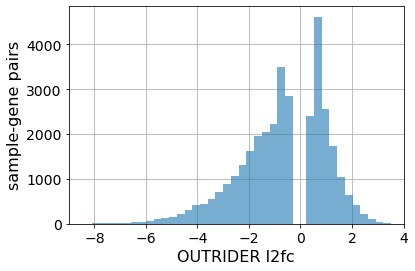

In [284]:
fig, ax = plt.subplots()

outrider_df.l2fc[outrider_df.l2fc>0].hist(bins=np.arange(0.22,4,0.3), alpha=0.6, color='tab:blue')
outrider_df.l2fc[outrider_df.l2fc<0].hist(bins=np.arange(-9,-0.22,0.3), alpha=0.6, color='tab:blue')

ax.set_axisbelow(True)
ax.set_xlim([-9,4])

ax.set_xlabel('OUTRIDER l2fc')
ax.set_ylabel('sample-gene pairs')

In [335]:
df = proximity.applymap(lambda x: names_matching.get(x,x)).sort_values(by='ass_gene_l2fc',ascending=False)

pd.options.display.min_rows = 16

df[['sampleID','AML_gene','ass_gene', 'ass_gene_l2fc', 'AML_gene_l2fc']]

sc_df = df.groupby(['sampleID','AML_gene']).ass_gene_l2fc.apply(lambda x:(x>0).sum()==len(x) or (x<0).sum()==len(x)).rename('sing_consensus').reset_index()
sc_df = sc_df[sc_df.sing_consensus]

In [341]:
df_consensus = sc_df.merge(df)

In [342]:
df_consensus = df_consensus.sort_values(by='ass_gene_l2fc', key=lambda x:abs(x), ascending=False).drop_duplicates(subset=['sampleID','AML_gene'], keep='first')

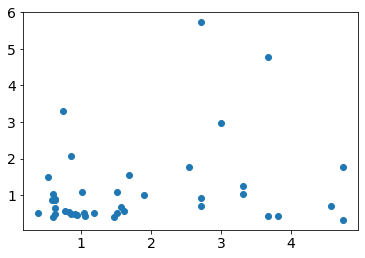

In [343]:
fig,ax = plt.subplots()

ax.scatter(df_consensus.ass_gene_l2fc.abs(),df_consensus.AML_gene_l2fc.abs())

In [344]:
df_consensus

,sampleID,AML_gene,sing_consensus,ass_gene,ass_gene_l2fc,AML_gene_l2fc,AML_gene_vars,ass_gene_vars,n_ass_genes
32,MLL_16593,CEBPA,True,CPPED1,-4.74,-1.78,0.0,1.0,9
41,MLL_16593,SF3B1,True,CPPED1,-4.74,-0.32,0.0,1.0,9
11,MLL_14748,TBL1XR1,True,ZNF718,-4.58,0.69,0.0,2.0,7
2,MLL_10655,SF3A1,True,LRP12,-3.81,-0.42,0.0,1.0,3
80,MLL_29371,CSNK1A1,True,SECTM1,-3.67,0.44,0.0,1.0,4
76,MLL_29371,BCOR,True,SECTM1,-3.67,-4.77,0.0,1.0,4
23,MLL_16241,BRCC3,True,F13A1,-3.31,-1.25,0.0,1.0,5
18,MLL_16241,BCOR,True,F13A1,-3.31,1.03,0.0,1.0,5
13,MLL_15976,BCORL1,True,ASRGL1,-3.00,-2.96,0.0,1.0,2
85,MLL_29692,CHEK2,True,C21orf91,-2.72,0.71,0.0,1.0,1


In [245]:
df[['sampleID','AML_gene']].drop_duplicates().shape

(70, 2)

In [166]:
#proximity.ass_gene.drop_duplicates().to_csv(data_dir + 'aml_association/ass_250.csv',index=None)

In [176]:
#select promoter variants only for associated genes

promoter_variants = pd.read_csv(data_dir + 'aml_association/promoter_variants/max_gnomAD_5e-4/promoters_5000_symm.tsv',
                               sep='\t', names=['chrom','pos', 'ref', 'alt', 'info_', 'vcf_name', 'geneID'])

gene_edges = pd.read_csv(data_dir + 'aml_association/associated_genes_GRCh37.bed',
                               sep='\t', names=['chrom','rstart', 'rstop', 'geneID'], usecols=[0,1,2,3])

promoter_variants = promoter_variants[promoter_variants.geneID.isin(proximity.ass_gene)]

promoter_variants = promoter_variants.merge(gene_edges, how='left')

#promoter_variants.to_csv(data_dir + 'aml_association/promoter_variants/max_gnomAD_5e-4/promoters_5000_symm_short.tsv',
#                         sep='\t', header=None, index=None)

In [175]:
data_dir + 'aml_association/promoter_variants/max_gnomAD_5e-4/promoters_5000_symm_short.tsv'

'/s/project/mll/sergey/effect_prediction/outrider/aml_association/promoter_variants/max_gnomAD_5e-4/promoters_5000_symm_short.tsv'

In [77]:
G = nx.from_pandas_edgelist(proximity,'AML_gene','ass_gene')

In [155]:
data_dir + 'aml_association/promoter_variants/max_gnomAD_5e-4/promoters_5000_symm.tsv'

'/s/project/mll/sergey/effect_prediction/outrider/aml_association/promoter_variants/max_gnomAD_5e-4/promoters_5000_symm.tsv'

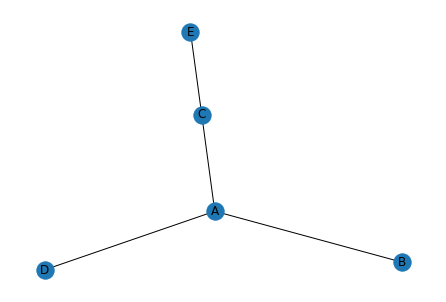

In [74]:
df = pd.DataFrame({ 'from':['A', 'B', 'C','A'], 'to':['D', 'A', 'E','C']})
 
# Build your graph
G=nx.from_pandas_edgelist(df, 'from', 'to')
 
# Plot it
nx.draw(G, with_labels=True)
plt.show()

In [10]:
#proximity = proximity.applymap(lambda x: names_matching.get(x,x))

#proximity = proximity[['AML_gene','ass_gene','sampleID']].sort_values(
#    by='AML_gene').set_index(['AML_gene','ass_gene'])

,ass_gene,AML_gene,sampleID,AML_gene_vars
0,ENSG00000111540,ENSG00000107736,MLL_00268,0.0
1,ENSG00000135655,ENSG00000107736,MLL_00268,0.0
2,ENSG00000274290,ENSG00000107736,MLL_00268,0.0
3,ENSG00000115649,ENSG00000107736,MLL_00268,0.0
4,ENSG00000198589,ENSG00000107736,MLL_00268,0.0
...,...,...,...,...
2324,ENSG00000115020,ENSG00000196712,MUC_00563,0.0
2325,ENSG00000072849,ENSG00000196712,MUC_00563,0.0
2326,ENSG00000198771,ENSG00000196712,MUC_00563,0.0
2327,ENSG00000198690,ENSG00000196712,MUC_00563,0.0


NameError: name 'w' is not defined